## Setup the notebook

In [1]:
import os, sys

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
    from kaggle_secrets import UserSecretsClient
    import subprocess
    
    user_secrets = UserSecretsClient()
    token = user_secrets.get_secret("git_token")
    
    repo_url = f"git+https://{token}@github.com/Blaku03/PitchAnalyzer_AI.git"
    
    subprocess.check_call(
        ["pip", "install", repo_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.STDOUT
    )
    video_path = "/kaggle/input/pitchtest/B1606b0e6_1 (91).mp4"
    output_path = "./output_video.avi"
else:
    # reloads the code during development
    %load_ext autoreload
    %autoreload 2
    # ensure project root (one level up) is on PATH
    ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if ROOT not in sys.path:
        sys.path.insert(0, ROOT)

    video_path = "../sample_data/B1606b0e6_1 (91).mp4"
    output_path = "../output_videos/output_video.avi"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

## Import models

In [2]:
from utils.import_models import ModelImporter
field_model = ModelImporter().download_field_model()
players_model = ModelImporter().download_player_model()

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/field_recognitionv1_0/1
Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1


## Demo of the field mapper


0: 544x960 1 pitch, 70.0ms
Speed: 2.7ms preprocess, 70.0ms inference, 242.6ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 1 pitch, 69.7ms
Speed: 2.8ms preprocess, 69.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 960)


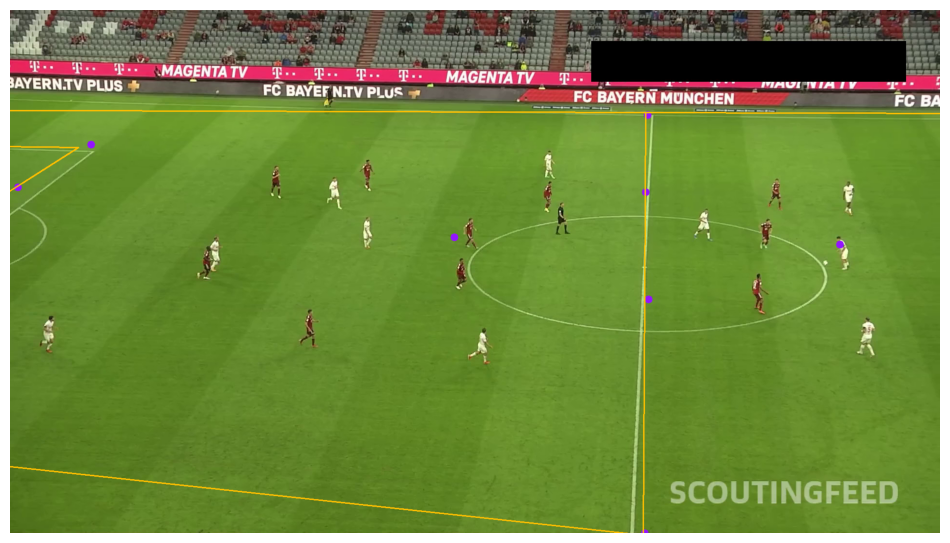

In [3]:
from utils.notebook_utils import show_image
from utils.video_utils import read_video
from trackers.pitch_tracker import PitchTracker
from annotators.pitch_annotator import PitchAnnotator

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

pitch_tracker = PitchTracker(field_model)
pitch_keypoints, confidence_mask = pitch_tracker.get_pitch_keypoints(first_frame)
pitch_edges = pitch_tracker.get_pitch_edges(first_frame)

show_image(PitchAnnotator.annotate_frame(first_frame.copy(), (pitch_keypoints,pitch_edges)))


0: 544x960 1 pitch, 66.7ms
Speed: 3.1ms preprocess, 66.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 960)


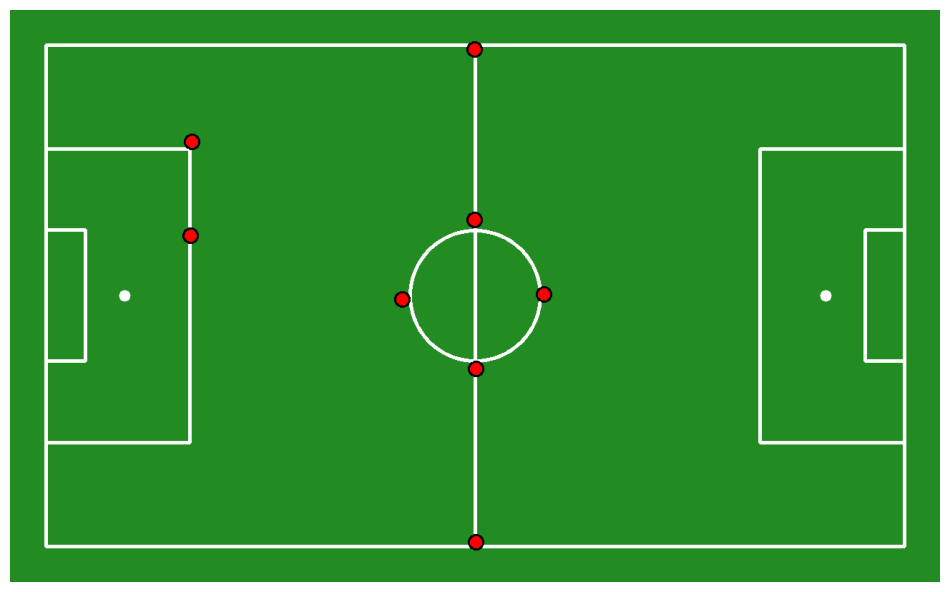

In [4]:
from utils.pitch_utils import draw_pitch, draw_points_on_pitch
from mapping_2d.soccer_field import SoccerPitchConfiguration
import supervision as sv

mapped_vert = pitch_tracker.map_points_2d(first_frame, pitch_keypoints.xy[0])

pitch_img = draw_pitch(SoccerPitchConfiguration())
pitch_img = draw_points_on_pitch(
    config=SoccerPitchConfiguration(),
    xy=mapped_vert.xy[0],
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=pitch_img)

show_image(pitch_img)

## Draw detected players on the 2d plane


0: 544x960 1 ball, 1 goalkeeper, 21 players, 1 referee, 32.1ms
1: 544x960 1 ball, 22 players, 1 referee, 32.1ms
2: 544x960 21 players, 2 referees, 32.1ms
3: 544x960 1 goalkeeper, 23 players, 1 referee, 32.1ms
4: 544x960 20 players, 2 referees, 32.1ms
5: 544x960 21 players, 1 referee, 32.1ms
6: 544x960 1 ball, 21 players, 1 referee, 32.1ms
7: 544x960 1 ball, 2 goalkeepers, 22 players, 2 referees, 32.1ms
8: 544x960 1 ball, 22 players, 1 referee, 32.1ms
9: 544x960 21 players, 2 referees, 32.1ms
Speed: 2.2ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 21 players, 2 referees, 33.5ms
1: 544x960 22 players, 2 referees, 33.5ms
2: 544x960 20 players, 2 referees, 33.5ms
3: 544x960 1 ball, 20 players, 2 referees, 33.5ms
4: 544x960 1 ball, 20 players, 2 referees, 33.5ms
5: 544x960 20 players, 2 referees, 33.5ms
6: 544x960 1 ball, 20 players, 2 referees, 33.5ms
7: 544x960 1 ball, 20 players, 2 referees, 33.5ms
8: 544x960 1 ball, 20 players, 2 ref

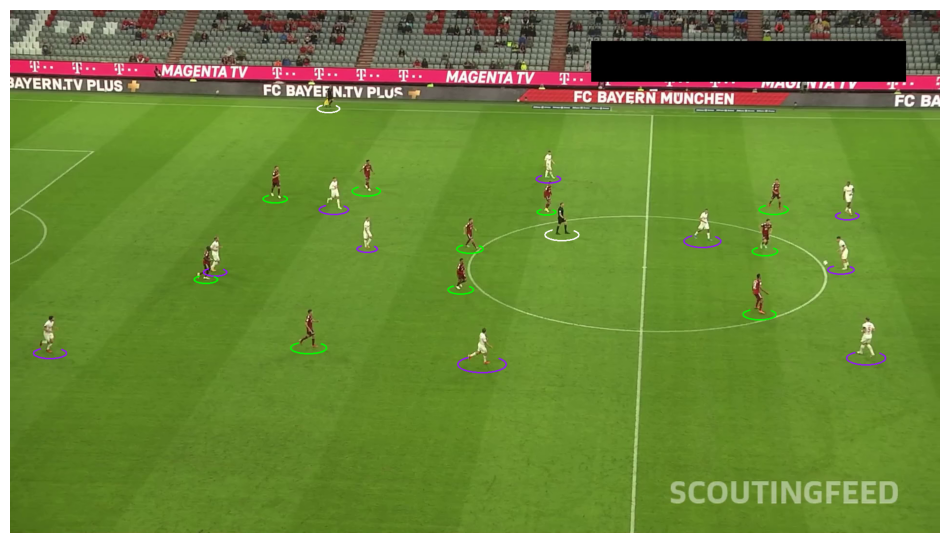

In [5]:
from annotators.game_entities_annotator import GameEntitiesAnnotator
from trackers.game_tracker import GameTracker

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_generator(frame_generator)

first_frame = next(frame_generator)
first_players_tracks = next(tracks_generator)

annotated_sample_image = GameEntitiesAnnotator.annotate_frame(first_frame.copy(), first_players_tracks)
show_image(annotated_sample_image)


0: 544x960 1 pitch, 71.4ms
Speed: 3.0ms preprocess, 71.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 960)


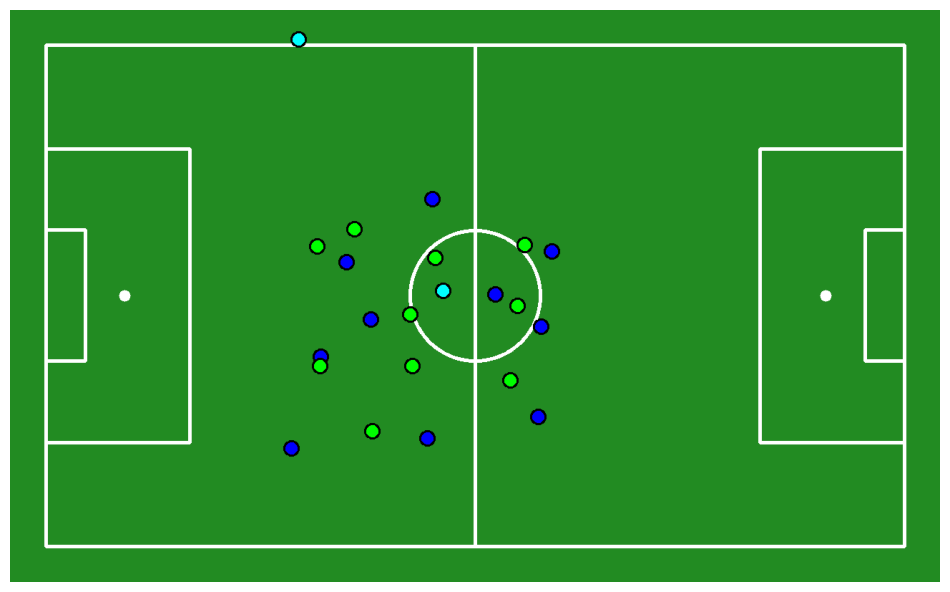

In [6]:
from annotators.pitch_2d_annotator import Pitch2DAnnotator

bottom_boxes = first_players_tracks.players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
mapped_2d_points = pitch_tracker.map_points_2d(first_frame, bottom_boxes)

show_image(Pitch2DAnnotator().annotate_frame(mapped_2d_points.xy[0], first_players_tracks))

In [7]:
# Annotate the full video
from utils.video_utils import save_video
import itertools

frame_generator = read_video(video_path)
frame_gen1, frame_gen2 = itertools.tee(frame_generator)

tracks_generator =  GameTracker(players_model).get_detections_generator(frame_gen1)
tracks_gen1, tracks_gen2 = itertools.tee(tracks_generator)

mapped_2d_points_generator = pitch_tracker.map_players_tracks_2d_generator(frame_gen2, tracks_gen1)
annotated_2d_field_generator = Pitch2DAnnotator().annotate_video(mapped_2d_points_generator, tracks_gen2)
save_video(annotated_2d_field_generator, output_path)


0: 544x960 1 goalkeeper, 23 players, 2 referees, 31.9ms
1: 544x960 1 goalkeeper, 23 players, 31.9ms
2: 544x960 23 players, 1 referee, 31.9ms
3: 544x960 1 ball, 1 goalkeeper, 24 players, 2 referees, 31.9ms
4: 544x960 1 ball, 21 players, 1 referee, 31.9ms
5: 544x960 1 ball, 1 goalkeeper, 21 players, 1 referee, 31.9ms
6: 544x960 1 goalkeeper, 23 players, 1 referee, 31.9ms
7: 544x960 2 balls, 1 goalkeeper, 21 players, 31.9ms
8: 544x960 1 ball, 1 goalkeeper, 21 players, 1 referee, 31.9ms
9: 544x960 1 ball, 1 goalkeeper, 21 players, 1 referee, 31.9ms
Speed: 2.2ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 1 ball, 20 players, 2 referees, 33.1ms
1: 544x960 21 players, 2 referees, 33.1ms
2: 544x960 22 players, 2 referees, 33.1ms
3: 544x960 20 players, 2 referees, 33.1ms
4: 544x960 1 ball, 20 players, 2 referees, 33.1ms
5: 544x960 1 ball, 20 players, 2 referees, 33.1ms
6: 544x960 20 players, 2 referees, 33.1ms
7: 544x960 1 ball, 20 players, 2

750